In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score

from utils import preprocessing
from utils.training import train, infer, predict_sexism

sns.set_style('darkgrid')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# BERT

## Datos

In [4]:
train_df = pd.read_csv('../../data/EXIST2021_training.tsv', sep='\t')

# Un simple pre-procesamiento
train_df['text'] = train_df['text'].apply(lambda text: preprocessing.preprocess(text))

# Codificamos las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(train_df['task1'])

train_df['label'] = label_encoder.transform(train_df['task1'])

train_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,1,twitter,en,"she calls herself "" anti-feminazi "" how about ...",sexist,ideological-inequality,1
1,EXIST2021,2,twitter,en,"now , back to these women , the brave and the ...",non-sexist,non-sexist,0
2,EXIST2021,3,twitter,en,"wow , your skirt is very short . what is it's ...",sexist,objectification,1
3,EXIST2021,4,twitter,en,incredible ! beautiful ! but i laughed so much...,non-sexist,non-sexist,0
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [5]:
test_df = pd.read_csv('../../data/EXIST2021_test.tsv', sep='\t')

# Un simple pre-procesamiento
test_df['text'] = test_df['text'].apply(lambda text: preprocessing.preprocess(text))

test_df['label'] = label_encoder.transform(test_df['task1'])

test_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,EXIST2021,6979,twitter,en,"he sounds like as ass , and very condescending .",non-sexist,non-sexist,0
2,EXIST2021,6980,twitter,en,"lol ! "" this behavior of not letting men tell ...",sexist,ideological-inequality,1
3,EXIST2021,6981,twitter,en,rights ? i mean yeah most women especially the...,sexist,ideological-inequality,1
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i ’ m seeing is...,non-sexist,non-sexist,0


In [6]:
# # Ya está preprocesado
# train_df = pd.read_csv('../../Data/EXIST2021_training_spell_checked.csv', sep=',')

# # Codificamos las etiquetas
# label_encoder = LabelEncoder()
# label_encoder.fit(train_df['task1'])

# train_df['label'] = label_encoder.transform(train_df['task1'])

# train_df.head()

In [7]:
# # Ya está preprocesado
# test_df = pd.read_csv('../../Data/EXIST2021_test_spell_checked.csv', sep=',')

# test_df['label'] = label_encoder.transform(test_df['task1'])

# test_df.head()

### Dataloaders

En [Huggingface models](https://huggingface.co/models) están los modelos pre-entrenados disponibles. Usaré [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) que está pre-entrenado en 102 idiomas con un corpus de Wikipedia.

In [8]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# bert = BertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer(['hello my name is dave']), tokenizer(['hola mi nombre es david'])

In [9]:
class DataSet:    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)
    
class DataSetText:    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)

In [10]:
ds_text_train = DataSetText(train_df)
ds_text_test = DataSetText(test_df)

print(f'Train: {len(ds_text_train)}')
print(f'Test: {len(ds_text_test)}')

Train: 6977
Test: 4368


In [11]:
# Si hago el batch más grande puede que no quepa en la GPU
BATCH_SIZE = 8

train_dl = DataLoader(
    ds_text_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True)

test_dl = DataLoader(
    ds_text_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

## Modelo

Hay ciertos hiperparámetros que se recomiendan para hacer fine-tuning con BERT, yo usaré los que se muestran en [Notes on BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://stephanheijl.com/notes_on_bert.html).

In [12]:
class SexismClassifier(nn.Module):
    def __init__(self):
        super(SexismClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        self.dropout = nn.Dropout(p=0.5)
                
        self.clf = nn.Sequential(nn.Linear(768, 2), 
                                 nn.Softmax(dim=1))
        
    def forward(self, ids, masks):
        # [batch_size, max_length] -> [batch_size, max_length, 768]
        bert_output = self.bert(input_ids=ids, attention_mask=masks, return_dict=True).last_hidden_state
        
        # [batch_size, max_length, 768] -> [batch_size, 768]
        # cls_output = bert_output[:,0,:]
        cls_output = torch.mean(bert_output, dim=1)
        
        cls_output = self.dropout(cls_output)
        
        # [batch_size, 768] -> [batch_size, 2]
        y = self.clf(cls_output)

        return y

In [13]:
model = SexismClassifier().to(device)

In [14]:
# berttokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# text = 'hello my name is dave'

# berttokenizer_dict = berttokenizer(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
# input_ids = berttokenizer_dict['input_ids'].to(device)
# attention_mask = berttokenizer_dict['attention_mask'].to(device)

# bert_output = model(input_ids, attention_mask)
# bert_output[:,0,:].shape, torch.mean(bert_output, dim=1).shape

In [15]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               81,315,072
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Sequential: 1-3                        --
|    └─Linear: 2-4                       1,538
|    └─Softmax: 2-5                      --
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0

### Entrenamiento

Epoch 5: train acc:0.8790137614678899 test acc:0.7527472527472527


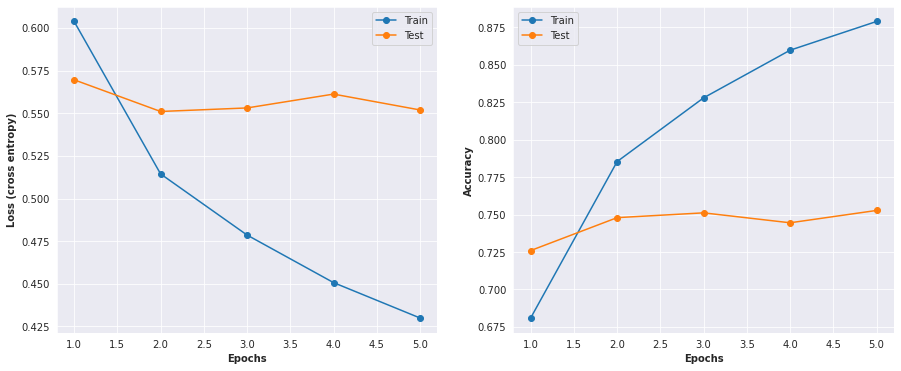

CPU times: user 11min 46s, sys: 32.3 s, total: 12min 19s
Wall time: 12min 15s


In [16]:
%time losses_train, losses_test, accs_train, accs_test = train(model, train_dl, test_dl, epochs=5, lr=1e-5)

### Evaluación

In [17]:
%time y_test, y_pred = infer(model, test_dl)

CPU times: user 19.2 s, sys: 232 ms, total: 19.4 s
Wall time: 19.6 s


In [18]:
print(classification_report(y_test, y_pred, target_names=['non-sexist', 'sexist']))

              precision    recall  f1-score   support

  non-sexist       0.75      0.73      0.74      2087
      sexist       0.76      0.77      0.77      2281

    accuracy                           0.75      4368
   macro avg       0.75      0.75      0.75      4368
weighted avg       0.75      0.75      0.75      4368



In [19]:
print(f'Accuracy: {round(100*accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {round(100*f1_score(y_test, y_pred), 4)}')

Accuracy: 75.2747
F1 score: 76.5625


In [20]:
text = 'shut up bitch and suck a dick'

predict_sexism(model, text, label=True)

'sexist'

- De igual manera, parece que hacer el spell-checking no ayuda. 
- Usar  `torch.mean(bert_output, dim=1)` en vez de `bert_output[:,0,:]` como entrada para el clasificador realmente ayuda.

|                **Model**                | **Accuracy** | **F1** |
|:---------------------------------------:|:------------:|:------:|
| BERT-base-multilingual-uncased, lr=1e-5 |     75.27    |  76.56 |
| BERT-base-multilingual-uncased, lr=2e-5 |     72.21    |  73.88 |
| BERT-base-multilingual-uncased, lr=3e-5 |     72.20    |  71.75 |



<!-- |                 **Model**                 | **Accuracy** | **F1** |
|:-----------------------------------------:|:------------:|:------:|
| 1-Dropout, torch.mean(bert_output, dim=1) |     75.27    |  76.55 |
|       1-Dropout, bert_output[:,0,:]       |    73.509    | 73.240 |
|       2-Dropout, bert_output[:,0,:]       |     74.18    |  76.22 |
|       3-Dropout, bert_output[:,0,:]       |     74.24    |  74.99 |
| 1-Dropout, torch.mean(bert_output, dim=1) |     75.27    |  76.55 |
| 2-Dropout, torch.mean(bert_output, dim=1) |       -      |    -   |
| 3-Dropout, torch.mean(bert_output, dim=1) |     74.52    |  74.81 | -->

Finalmente, guardamos el modelo.

In [21]:
! mkdir models

mkdir: no se puede crear el directorio «models»: El archivo ya existe


In [22]:
torch.save(model.state_dict(), 'models/sexism-classifier-task1.pt')